In [4]:
# load packages
import pandas as pd
import re
import gffutils
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#  Functions

In [5]:
# function to count the number of values seperated by comma in a dataframe field
# if NaN is present, it will be counted as 0

def count_comma_separated_values(df, column_name):
    def count_values(cell):
        if pd.isna(cell):
            return 0
        return len(str(cell).split(','))

    return df[column_name].apply(count_values)



def check_length_values(row, percent):
    min_value = row.min()
    max_value = row.max()

    # Calculate the 1% range
    ten_percent = min_value * percent * 0.01

    # Check if all values are within 1% of each other
    return max_value >= min_value + ten_percent


def add_length_category(df):
    # Select only the relevant columns
    df_subset = df[['ref_length_1G', 'ref_length_2G', 'ref_length_3G', 'ref_length_4G']]


    df_subset = df_subset.astype(int)

    # print max and min values of each row
    df['length_category'] = 'unclassified'

    df.loc[df_subset.apply(lambda x: check_length_values(x, 0), axis=1), 'length_category'] = 'less_1%_difference'
    df.loc[df_subset.apply(lambda x: check_length_values(x, 1), axis=1), 'length_category'] = 'more_1%_difference'

    df.loc[df_subset.apply(lambda x: check_length_values(x, 5), axis=1), 'length_category'] = 'more_5%_difference'

    df.loc[df_subset.apply(lambda x: check_length_values(x, 10), axis=1), 'length_category'] = 'more_10%_difference'


    df.loc[df_subset.apply(lambda x: check_length_values(x, 20), axis=1), 'length_category'] = 'more_20%_difference'
    return df

def add_longest_transcript(df):

    df['haplotype_with_longest_annotation'] = df[['ref_length_1G', 'ref_length_2G', 'ref_length_3G', 'ref_length_4G']].idxmax(axis=1)
    mask = (df[['ref_length_1G', 'ref_length_2G', 'ref_length_3G', 'ref_length_4G']].nunique(axis=1) == 1)
    df.loc[mask, 'haplotype_with_longest_annotation'] = 'equal_lengths'
    df['haplotype_with_longest_annotation'] = df['haplotype_with_longest_annotation'].str.replace('ref_length_', '')
    #df.loc[df['length_category'] == 'less_1%_difference', 'haplotype_with_longest_annotation'] = 'lengths_within_5%'
    return df

def make_barplot(df):
    plt.figure(figsize=(5, 5))
    # Sort the DataFrame by the 'length_category' column
    custom_order = ['less_1%_difference','more_1%_difference', 'more_5%_difference', 'more_10%_difference', 'more_20%_difference']  # replace with your actual categories
    df['length_category'] = pd.Categorical(df['length_category'], categories=custom_order, ordered=True)
    # chagne the haplotype_with_longest_annotation to a categorical variable
    df['haplotype_with_longest_annotation'] = pd.Categorical(df['haplotype_with_longest_annotation'], categories=['2G', '4G', '1G', '3G', 'equal_lengths'], ordered=True)
    #sns.countplot(x='length_category', hue='haplotype_with_longest_annotation', data=df)
    sns.histplot(data=df, x='length_category', hue='haplotype_with_longest_annotation', multiple='stack')
    plt.xlabel('Length Category')
    plt.ylabel('Count')
    # turn the x-axis labels
    plt.xticks(rotation=90)
    plt.title('Counts of Length Categories')
    plt.tight_layout()
    # show the plot
    plt.show()

def get_transcript_lengths(gff_file):
    # Create a database from the GFF file
    db = gffutils.create_db(gff_file, dbfn='gff.db', force=True, keep_order=True,
                            merge_strategy='merge', sort_attribute_values=True)

    # Initialize an empty dictionary to store transcript lengths
    transcript_lengths = {}

    # Iterate over all features of type 'exon' in the GFF file
    for exon in db.features_of_type('gene'):

        parent_id = exon.attributes['ID'][0]
        length = exon.end - exon.start + 1
        if parent_id not in transcript_lengths:
            transcript_lengths[parent_id] = 0

        transcript_lengths[parent_id] += length
    print(transcript_lengths)

    # Create a DataFrame from the dictionary
    df = pd.DataFrame.from_dict(transcript_lengths, orient='index', columns=['ref_length'])
    return df

def get_transcript_lengths_exon(gff_file):
    # Create a database from the GFF file
    db = gffutils.create_db(gff_file, dbfn='gff.db', force=True, keep_order=True,
                            merge_strategy='merge', sort_attribute_values=True)

    # Initialize a dictionary to store transcript lengths and start coordinates
    transcript_info = {}

    # Iterate over all features of type 'exon' in the GFF file
    for exon in db.features_of_type('exon'):
        parent_id = exon.attributes['Parent'][0]
        length = exon.end - exon.start + 1
        
        if parent_id not in transcript_info:
            # Get the parent transcript feature
            parent = db[parent_id]
            transcript_info[parent_id] = {'ref_length': 0, 'parent_start': parent.start}
        
        transcript_info[parent_id]['ref_length'] += length
    
    # Convert dictionary to DataFrame
    df = pd.DataFrame.from_dict(transcript_info, orient='index')
    return df

def get_multimapping_tags(df):
    # extract the tnames that contain "&"
    df = df[df['haplotype_id'].str.contains('&')]
    print(df)
    # rename num_reads to multimapping_reads
    df = df.rename(columns={'num_reads': 'multimapping_reads'})
    return df

def sum_sample_counts(df):
    # sum the counts for each sample and skip the first column
    df['num_reads'] = df.iloc[:, 1:].sum(axis=1)

    return df

pd.options.mode.chained_assignment = None

sns.set_theme(style='ticks', rc={
    'figure.figsize': (4, 4),  # figure size in inches
    'axes.labelsize': 10,           # font size of the x and y labels
    'xtick.labelsize': 10,          # font size of the tick labels
    'ytick.labelsize': 10,          # font size of the tick labels
    'legend.fontsize': 7,          # font size of the legend
    "axes.spines.right": False, 
    "axes.spines.top": False})



# Load input file
def load_input(input_file):
    return pd.read_csv(input_file, sep='\t')

def add_mulitmapping_ratio( df, multi):
    # join the two dataframes
    df = df.join(multi.set_index('Synt'), on='Synt')
    # calculate the ratio of multimapping reads vs total reads
    df['multimapping_ratio'] = df['multimapping_reads'] / (df['hap1'] + df['hap2'] + df['hap3'] +  df['hap4']+ df['multimapping_reads'])
    # add a tag if the multimapping ratio is above 0.25
    df['multimapping_tag'] = np.where(df['multimapping_ratio'] > 0.25, 'multimapping', 'unique')
    return df

def get_allele_ratio(df):
    # replace NaN with 0
    df = df.fillna(0)
    df['allele_ratio_hap1'] = df['1'] / (df['1'] + df['2'] + df['3'] + df['4'])
    df['allele_ratio_hap2'] = df['2'] / (df['1'] + df['2'] + df['3'] + df['4'])
    df['allele_ratio_hap3'] = df['3'] / (df['1'] + df['2'] + df['3'] + df['4'])
    df['allele_ratio_hap4'] = df['4'] / (df['1'] + df['2'] + df['3'] + df['4'])

    return df

def plot_hist(df, my_hue='multimapping_tag'):
    # Ensure NaN allele ratios are set to 0
    #df = df.fillna(0)
    
    # Identify haplotype columns dynamically
    hap_cols = [col for col in df.columns if col.startswith('allele_ratio_hap')]
    
    # Set up the plotting grid for side-by-side histograms
    fig, axes = plt.subplots(1, len(hap_cols), figsize=(4 * len(hap_cols), 4), sharey=True)

    # If there's only one haplotype column, axes won't be an array
    if len(hap_cols) == 1:
        axes = [axes]
    
    # Loop over haplotype columns and plot
    for ax, hap_col in zip(axes, hap_cols):
        sns.histplot(
            data=df,
            x=hap_col,
            bins=100,
            hue=my_hue,
            multiple='stack',
            ax=ax
        )
        ax.set_title(f'Histogram: {hap_col}')
        ax.set_xlim(0, 1)
        #ax.set_ylim(0, 300)
        ax.set_xlabel('Allele Ratio')
        ax.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

# Parsing Genespace pangenes


In [67]:
pangenes_file = "/scratch/nadjafn/potato-allelic-orthogroups/test_hap1_df.txt"
#pangenes_file = "/scratch/nadjafn/potato-allelic-orthogroups/work/fe/f989cd4f2bfaeee4e67468fdd5ad2c/ATL_v3.hc_gene_models.repr_genespace.tsv"
pangenes = pd.read_csv(pangenes_file, sep="\t", header=0, index_col=False)

# drop last of the duplicated rows
pangenes = pangenes.drop_duplicates()

In [70]:
# remove the + and * from the gene names
pangenes_gene = pangenes.map(lambda x: x.replace("+", "").replace("*", "") if isinstance(x, str) else x)
# print the number of uniuq values in the hap1 hap2 hap3 hap4 columns
print(pangenes_gene['hap1'].nunique()+ pangenes_gene['hap2'].nunique() +pangenes_gene['hap3'].nunique() + pangenes_gene['hap4'].nunique())


# print number of non unique values in the hap1 hap2 hap3 hap4 columns
print(pangenes['hap1'].value_counts())
print(pangenes['hap2'].value_counts())
print(pangenes['hap3'].value_counts())
print(pangenes['hap4'].value_counts())

173903
hap1
Soltu.Des.v1_C07H1G012140.1*    37
Soltu.Des.v1_C04H1G013890.1*    18
Soltu.Des.v1_C11H1G019380.1*    17
Soltu.Des.v1_C11H1G021070.1*    15
Soltu.Des.v1_C08H1G016260.1*    15
                                ..
Soltu.Des.v1_C04H1G025780.1      1
Soltu.Des.v1_C04H1G025790.1      1
Soltu.Des.v1_C04H1G025800.1      1
Soltu.Des.v1_C04H1G025810.3      1
Soltu.Des.v1_C12H1G039060.1*     1
Name: count, Length: 48483, dtype: int64
hap2
Soltu.Des.v1_C12H2G014850.1*    31
Soltu.Des.v1_C10H2G007190.1*    20
Soltu.Des.v1_C10H2G045430.1*    13
Soltu.Des.v1_C09H2G036830.1*    13
Soltu.Des.v1_C12H2G027210.1*    12
                                ..
Soltu.Des.v1_C02H2G032100.1      1
Soltu.Des.v1_C02H2G032110.1      1
Soltu.Des.v1_C02H2G032120.1      1
Soltu.Des.v1_C02H2G032130.1      1
Soltu.Des.v1_C12H2G045140.1*     1
Name: count, Length: 51482, dtype: int64
hap3
Soltu.Des.v1_C08H3G013000.1*    25
Soltu.Des.v1_C01H3G018100.1*    21
Soltu.Des.v1_C06H3G021860.1*    18
Soltu.Des.v1_C08H3G01

In [62]:
for hap in ['hap1', 'hap2', 'hap3', 'hap4']:
    pangenes[f'{hap}_count'] = count_comma_separated_values(pangenes, hap).astype(str) + hap

# add a category if all the haplotypes dont't contain a * or + in the gene nam
pangenes['true_synteny'] = 'synteny'
pangenes.loc[(pangenes['hap1'].str.contains('\*') | pangenes['hap2'].str.contains('\*') | pangenes['hap3'].str.contains('\*') | pangenes['hap4'].str.contains('\*')), 'true_synteny'] = 'no_synteny'
pangenes.loc[(pangenes['hap1'].str.contains('\+') | pangenes['hap2'].str.contains('\+') | pangenes['hap3'].str.contains('\+') | pangenes['hap4'].str.contains('\+')), 'true_synteny'] = 'no_synteny'


# merge all the haplotype counts into one column
pangenes['synteny_category'] = pangenes['hap1_count'] + '_' + pangenes['hap2_count'] + '_' + pangenes['hap3_count'] + '_' + pangenes['hap4_count'] + '_' + pangenes['true_synteny']






<Axes: ylabel='count'>

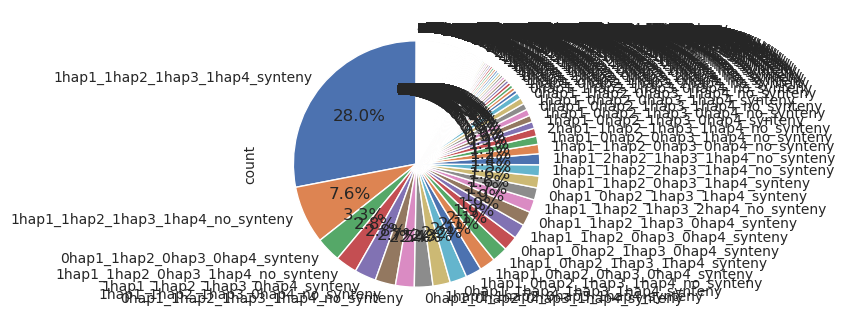

In [63]:
# count the occurence of each synteny category
synteny_counts = pangenes['synteny_category'].value_counts()
synteny_counts
# make a pie charr to show the distribution of synteny categories
synteny_counts.plot.pie(autopct='%1.1f%%', startangle=90)

In [64]:
# add a synt_id colum to the dataframe
pangenes.reset_index(inplace=False)
pangenes['Synt_id'] = pangenes.index

# select only the rows that have the category 1hap1_1hap2_1hap3_1hap4
pangenes = pangenes[pangenes['synteny_category'] == '1hap1_1hap2_1hap3_1hap4_synteny']
# pivot the table to have the Synt_id as the index and the hap1 hap2 hap3 hap4 as the values

# melt 
pangenes = pangenes.reset_index()
pangenes = pangenes.melt(id_vars='Synt_id', value_vars=['hap1', 'hap2', 'hap3', 'hap4'], value_name='haplotype_id')
# rename variable to haplotype
pangenes = pangenes.rename(columns={'variable': 'haplotype'})

## Check for the genes that are syntelogs the length difference between the haplotypes

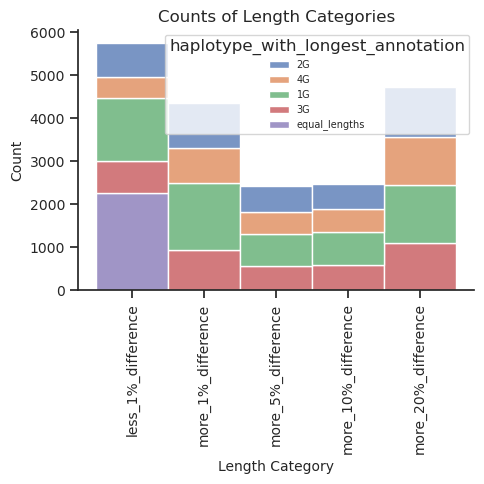

In [65]:
ref_lengths = get_transcript_lengths_exon('/scratch/nadjafn/potato-allelic-orthogroups/results/0_LongestIsofrom/Desiree.longest_isoforms.gff')
#ref_lengths = get_transcript_lengths_exon('/scratch/nadjafn/potato-allelic-orthogroups/results/0_LongestIsofrom/ATL_v3.hc_gene_models.repr.longest_isoforms.gff')
ref_lengths['haplotype_id'] = ref_lengths.index

# Merge the two dataframes
df_synt_lengths = pd.merge(pangenes, ref_lengths, on='haplotype_id', how='inner')

# group the haplotypes ids by synteny id
haplotype_ids = df_synt_lengths.groupby('Synt_id')['haplotype_id'].apply(list).reset_index()

# sort by Synt_id and print duplicated ones
haplotype_ids = haplotype_ids.sort_values(by='Synt_id')

# print duplicated Synt_ids to check if there are any
df_synt_pivot = df_synt_lengths.pivot(index='Synt_id', columns=['haplotype'], values=['ref_length','parent_start'])
# flatten the columns
df_synt_pivot.columns = ['_'.join(col) for col in df_synt_pivot.columns]
df_synt_pivot = pd.merge(df_synt_pivot, haplotype_ids, on='Synt_id', how='inner')


# # drop the synteny id column
# df_synt_pivot.index = df_synt_pivot['Synt_id']
# df_synt_pivot = df_synt_pivot.drop(columns=['Synt_id'])
# # rename the columns
# df_synt_pivot
df_synt_pivot.columns = ['Synt_id','ref_length_1G', 'ref_length_2G', 'ref_length_3G', 'ref_length_4G','parent_start_1G', 'parent_start_2G', 'parent_start_3G', 'parent_start_4G', 'haplotype_id']
# drop rows with missing values
df_synt_pivot = df_synt_pivot.dropna()
df_length = add_length_category(df_synt_pivot)
df_length_cat = add_longest_transcript(df_length)
make_barplot(df_length_cat)

In [179]:
# print the haplotype ids that have more than 20% difference in length
df_length_cat[df_length_cat['length_category'] == 'more_20%_difference']['haplotype_id'].values

# print the row containing this gene Soltu.Des.v1_C12H1G038990.1
#df_synt_pivot[df_synt_pivot['haplotype_id'].str.contains('Soltu.Des.v1_C12H1G038990.1')]

array([list(['Soltu.Des.v1_C01H1G000010.6', 'Soltu.Des.v1_C01H2G005280.2', 'Soltu.Des.v1_C01H3G000010.2', 'Soltu.Des.v1_C01H4G015600.1']),
       list(['Soltu.Des.v1_C01H1G000050.1', 'Soltu.Des.v1_C01H2G005240.1', 'Soltu.Des.v1_C01H3G000050.1', 'Soltu.Des.v1_C01H4G000060.1']),
       list(['Soltu.Des.v1_C01H1G000100.1', 'Soltu.Des.v1_C01H2G005190.1', 'Soltu.Des.v1_C01H3G000100.1', 'Soltu.Des.v1_C01H4G000140.1']),
       ...,
       list(['Soltu.Des.v1_C12H1G038990.1', 'Soltu.Des.v1_C12H2G045070.1', 'Soltu.Des.v1_C07H3G008820.1', 'Soltu.Des.v1_C03H4G035510.1']),
       list(['Soltu.Des.v1_C12H1G038990.1', 'Soltu.Des.v1_C12H2G045070.1', 'Soltu.Des.v1_C08H3G018810.1', 'Soltu.Des.v1_C03H4G035510.1']),
       list(['Soltu.Des.v1_C12H1G039060.1', 'Soltu.Des.v1_C12H2G045140.1', 'Soltu.Des.v1_C12H3G038770.1', 'Soltu.Des.v1_C12H4G021400.1'])],
      dtype=object)

In [151]:
df_length_cat[df_length_cat['length_category'] == 'less_1%_difference']['haplotype_id'].values

array([list(['Soltu.Des.v1_C01H1G000070.1', 'Soltu.Des.v1_C01H2G005220.1', 'Soltu.Des.v1_C01H3G000070.1', 'Soltu.Des.v1_C01H4G000100.1']),
       list(['Soltu.Des.v1_C01H1G000180.1', 'Soltu.Des.v1_C01H2G005110.1', 'Soltu.Des.v1_C01H3G000180.1', 'Soltu.Des.v1_C01H4G000220.1']),
       list(['Soltu.Des.v1_C01H1G000260.1', 'Soltu.Des.v1_C01H2G005030.1', 'Soltu.Des.v1_C01H3G000240.1', 'Soltu.Des.v1_C01H4G000300.1']),
       ...,
       list(['Soltu.Des.v1_C12H1G038660.1', 'Soltu.Des.v1_C12H2G044760.1', 'Soltu.Des.v1_C12H3G038460.1', 'Soltu.Des.v1_C12H4G036760.1']),
       list(['Soltu.Des.v1_C12H1G038840.1', 'Soltu.Des.v1_C12H2G044950.1', 'Soltu.Des.v1_C12H3G038630.1', 'Soltu.Des.v1_C12H4G036940.1']),
       list(['Soltu.Des.v1_C12H1G038940.1', 'Soltu.Des.v1_C12H2G045020.1', 'Soltu.Des.v1_C12H3G038660.1', 'Soltu.Des.v1_C12H4G037040.1'])],
      dtype=object)